In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import pandas as pd

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats

style.use('default')
import matplotlib.path as mpath
import utils

#### let's get the VGPM satellite data

In [2]:
%%time
files = sorted(glob(f'/glade/work/kristenk/satellite_data/VGPM/netcdf/vgpm.???????.all.nc'))       
ds_vgpm = xr.open_mfdataset(files, concat_dim="time", combine='nested',
                       #preprocess=preprocess
                      ).compute()

CPU times: user 4.2 s, sys: 8.61 s, total: 12.8 s
Wall time: 50.4 s


In [3]:
ds_vgpm = ds_vgpm.where(ds_vgpm > -9999.)

In [4]:
time = pd.date_range(start="2003-01-01", end="2022-01-01",freq="M")

In [5]:
ds_vgpm['time']= time

In [6]:
%%time
ds_vgpm_ann = ds_vgpm.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 12.4 s, sys: 4.95 s, total: 17.3 s
Wall time: 20.1 s


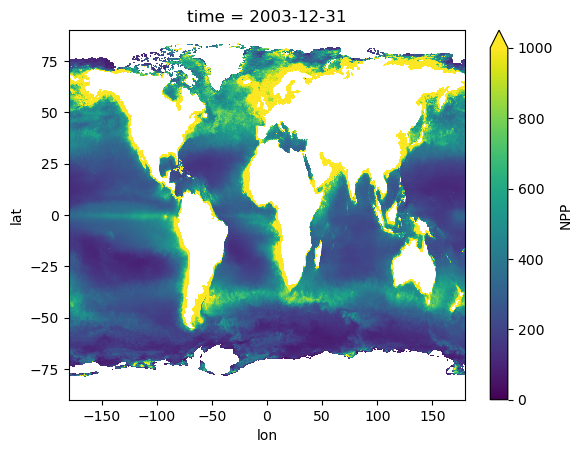

In [7]:
ds_vgpm_ann.NPP.isel(time=0).plot(vmin=0,vmax=1000)

In [8]:
ds_vgpm

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 228)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
  * time     (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2021-12-31
Data variables:
    NPP      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    file_in:  /glade/work/kristenk/satellite_data/VGPM/vgpm.2003001.all.xyz

In [9]:
ds_vgpm_mean = ds_vgpm_ann.mean(dim='time')

### Now get CbPM

In [10]:
%%time
files = sorted(glob(f'/glade/work/kristenk/satellite_data/CBPM/cbpm.???????.nc'))       
ds_cbpm = xr.open_mfdataset(files, concat_dim="time", combine='nested').compute()

CPU times: user 1.68 s, sys: 1.45 s, total: 3.13 s
Wall time: 20.5 s


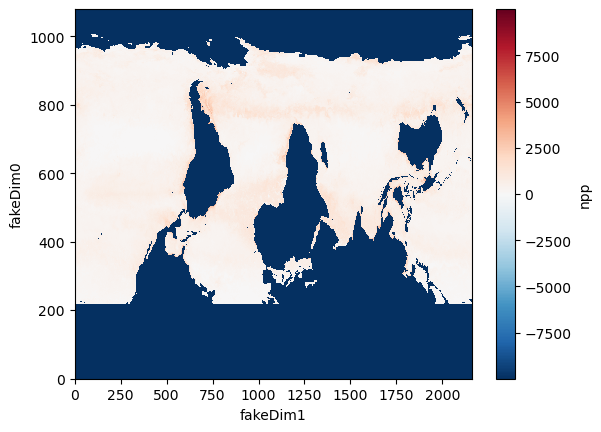

In [11]:
ds_cbpm.npp.isel(time=0).plot()

### cycle through the timeslices and flip right side up

In [12]:
times = len(ds_cbpm.time)
times

228

In [13]:
%%time 
### do first ts
tmp = np.flipud(ds_cbpm.npp.isel(time=0).values)
npp = xr.DataArray(tmp,dims=('lat','lon'))
    
## do the rest
for ts in np.arange(1,times,1):
    #print(ts)
    tmp = np.flipud(ds_cbpm.npp.isel(time=ts).values)
    tmp = xr.DataArray(tmp,dims=('lat','lon'))

    npp = xr.concat([npp,tmp],dim='time')

CPU times: user 42.9 s, sys: 43 s, total: 1min 25s
Wall time: 1min 37s


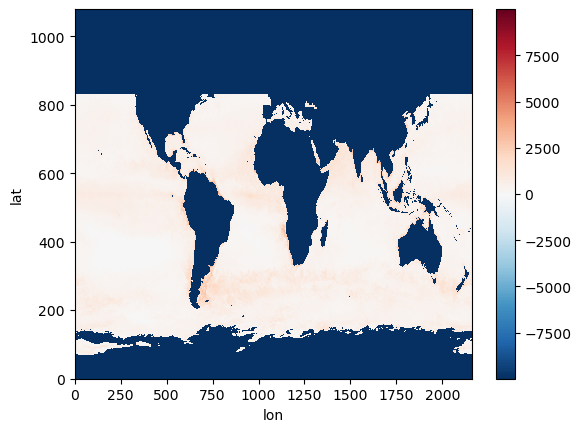

In [14]:
npp.isel(time=-1).plot()

In [15]:
ds_cbpm = xr.Dataset()
ds_cbpm['npp'] = npp

In [16]:
ds_cbpm['lat'] = np.arange(-90,90,1/6)
ds_cbpm['lon'] = np.arange(-180,180,1/6)

In [17]:
ds_cbpm['npp'] = ds_cbpm.npp.where(ds_cbpm.npp>0)

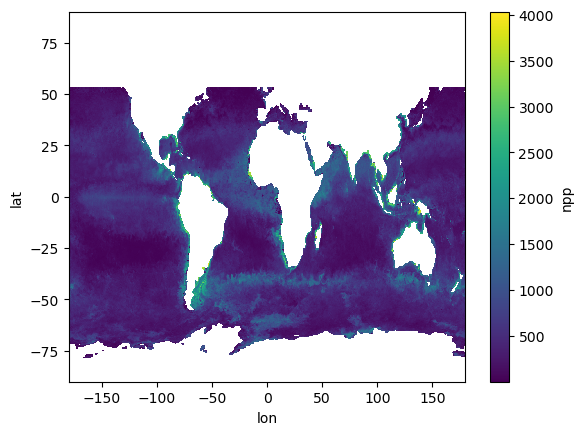

In [18]:
ds_cbpm.npp.isel(time=0).plot()

In [19]:
ds_cbpm['time' ]= time

In [20]:
%%time
ds_cbpm_ann = ds_cbpm.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2.02 s, sys: 517 ms, total: 2.53 s
Wall time: 2.75 s


In [21]:
ds_cbpm_mean = ds_cbpm_ann.mean(dim='time')

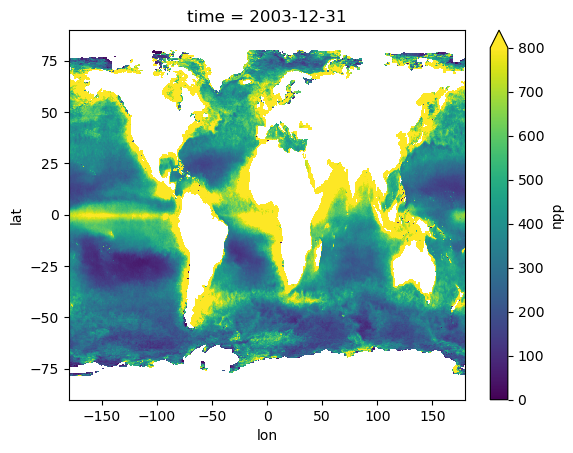

In [22]:
ds_cbpm_ann.npp.isel(time=0).plot(vmin=0,vmax=800)

### calculate area at 1/6° for CbPM

In [23]:
len(ds_cbpm_ann.lat)

1080

In [24]:
len(ds_cbpm_ann.lon)

2160

In [25]:
area = xr.DataArray(np.zeros([1080,2160]), dims=('lat','lon'))

j=0

for lat in ds_cbpm_ann.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1./6. #res in degrees
    resolution_lon =1./6. #res in degrees

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds_cbpm_ann['area']=area

### Calculate area at 1/12° for the VGPM

In [26]:
len(ds_vgpm_ann.lat)

2160

In [27]:
len(ds_vgpm_ann.lon)

4320

In [28]:
area = xr.DataArray(np.zeros([2160,4320]), dims=('lat','lon'))

j=0

for lat in ds_vgpm_ann.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1./12. #res in degrees
    resolution_lon =1./12. #res in degrees

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds_vgpm_ann['area']=area

### Make timeseries within some lon lat boxes

In [29]:
############ Equatorial Pacific
box1_latmin = -5.
box1_latmax = 5.
box1_lonmin = -165.
box1_lonmax = -135.

########### Subtropical North Atlantic
box2_latmin = 20.
box2_latmax = 35.
box2_lonmin = -50.
box2_lonmax = -25.

########### South of Africa
box3_latmin = -55.
box3_latmax = -45.
box3_lonmin = 30.
box3_lonmax = 45.

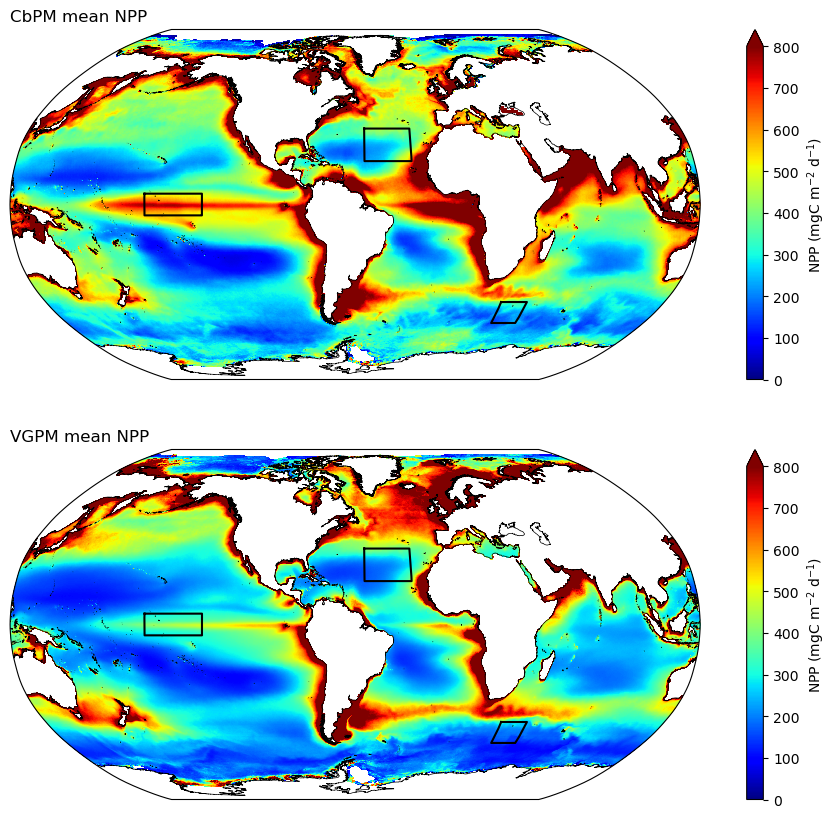

In [30]:
fig = plt.figure(figsize=(12,10))


#----------
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CbPM mean NPP', loc='left')

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat, 
                 ds_cbpm_mean.npp,
                 vmin=0, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mgC m$^{-2}$ d$^{-1}$)')

#################
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('VGPM mean NPP', loc='left')

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat, 
                 ds_vgpm_mean.NPP,
                 vmin=0, vmax=800, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mgC m$^{-2}$ d$^{-1}$)')


In [31]:
ones_v = np.full((2160,4320),1,dtype=int)
ones_v = xr.DataArray(ones_v,dims=('lat','lon'))
ones_v = ones_v.where(ds_vgpm_mean.NPP>-9999)

In [32]:
ones_c = np.full((1080,2160),1,dtype=int)
ones_c = xr.DataArray(ones_c,dims=('lat','lon'))
ones_c = ones_c.where(ds_cbpm_mean.npp>-9999)

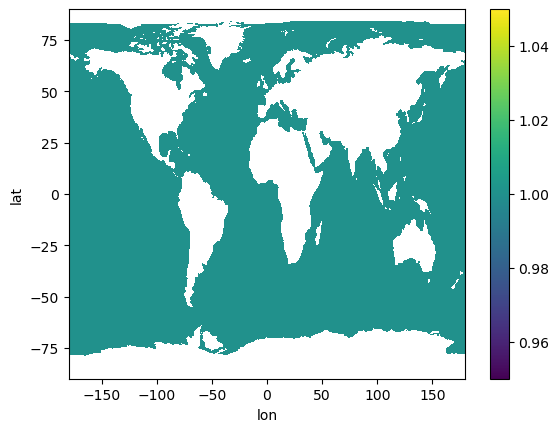

In [33]:
ones_v.plot()

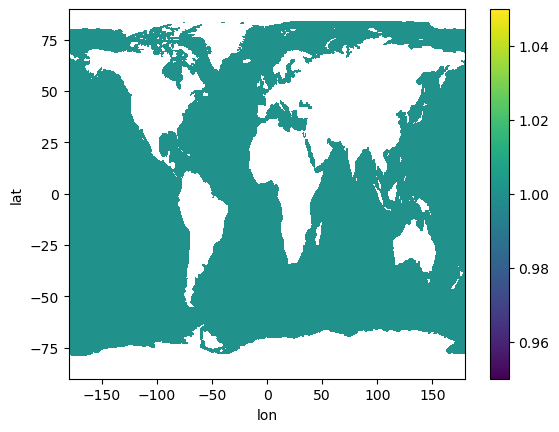

In [34]:
ones_c.plot()

### Make timeseries

In [35]:
ts_box1_v = xr.Dataset({v: ds_vgpm_ann[v] for v in ['time']})
ts_box1_c = xr.Dataset({v: ds_cbpm_ann[v] for v in ['time']})

## do vgpm
mask = ones_v.where(ds_vgpm_ann.lat<box1_latmax).where(ds_vgpm_ann.lat>box1_latmin).where(ds_vgpm_ann.lon<box1_lonmax).where(ds_vgpm_ann.lon>box1_lonmin)
masked_var = ds_vgpm_ann['NPP'].where(mask==1)
masked_area = ds_vgpm_ann.area.where(mask==1)
ts_box1_v['npp']  = (masked_var * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

## do cbpm
mask = ones_c.where(ds_cbpm_ann.lat<box1_latmax).where(ds_cbpm_ann.lat>box1_latmin).where(ds_cbpm_ann.lon<box1_lonmax).where(ds_cbpm_ann.lon>box1_lonmin)
masked_var = ds_cbpm_ann['npp'].where(mask==1)
masked_area = ds_cbpm_ann.area.where(mask==1)
ts_box1_c['npp']  = (masked_var * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

In [36]:
ts_box2_v = xr.Dataset({v: ds_vgpm_ann[v] for v in ['time']})
ts_box2_c = xr.Dataset({v: ds_cbpm_ann[v] for v in ['time']})

## do vgpm
mask = ones_v.where(ds_vgpm_ann.lat<box2_latmax).where(ds_vgpm_ann.lat>box2_latmin).where(ds_vgpm_ann.lon<box2_lonmax).where(ds_vgpm_ann.lon>box2_lonmin)
masked_var = ds_vgpm_ann['NPP'].where(mask==1)
masked_area = ds_vgpm_ann.area.where(mask==1)
ts_box2_v['npp']  = (masked_var * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

## do cbpm
mask = ones_c.where(ds_cbpm_ann.lat<box2_latmax).where(ds_cbpm_ann.lat>box2_latmin).where(ds_cbpm_ann.lon<box2_lonmax).where(ds_cbpm_ann.lon>box2_lonmin)
masked_var = ds_cbpm_ann['npp'].where(mask==1)
masked_area = ds_cbpm_ann.area.where(mask==1)
ts_box2_c['npp']  = (masked_var * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

In [37]:
ts_box3_v = xr.Dataset({v: ds_vgpm_ann[v] for v in ['time']})
ts_box3_c = xr.Dataset({v: ds_cbpm_ann[v] for v in ['time']})

## do vgpm
mask = ones_v.where(ds_vgpm_ann.lat<box3_latmax).where(ds_vgpm_ann.lat>box3_latmin).where(ds_vgpm_ann.lon<box3_lonmax).where(ds_vgpm_ann.lon>box3_lonmin)
masked_var = ds_vgpm_ann['NPP'].where(mask==1)
masked_area = ds_vgpm_ann.area.where(mask==1)
ts_box3_v['npp']  = (masked_var * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

## do cbpm
mask = ones_c.where(ds_cbpm_ann.lat<box3_latmax).where(ds_cbpm_ann.lat>box3_latmin).where(ds_cbpm_ann.lon<box3_lonmax).where(ds_cbpm_ann.lon>box3_lonmin)
masked_var = ds_cbpm_ann['npp'].where(mask==1)
masked_area = ds_cbpm_ann.area.where(mask==1)
ts_box3_c['npp']  = (masked_var * masked_area).sum(dim=('lon','lat')) / masked_area.sum(dim=('lon','lat'))

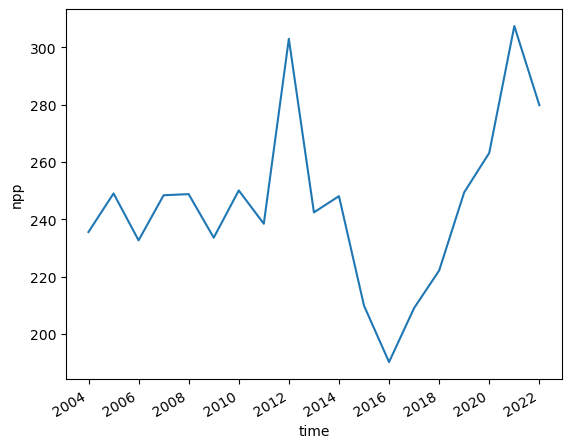

In [38]:
ts_box3_c['npp'].plot()

### Get NPP from the model for these same years

In [39]:
variables = ['photoC_TOT_zint']
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
keep_vars=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [40]:
%%time

ds = xr.Dataset()


for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.195801-202112.nc'))

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

photoC_TOT_zint
CPU times: user 193 ms, sys: 38.5 ms, total: 231 ms
Wall time: 517 ms


In [41]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### Make annual means and then trim dataset to 2003 to 2021

In [42]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

In [43]:
ds_ann.time[45:64]

<xarray.DataArray 'time' (time: 19)>
array([cftime.datetime(2003, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2004, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2005, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2006, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2007, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2008, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2009, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2010, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2011, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2012, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2013, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2014, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2015, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2016, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2017, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2018, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2019, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2020, 12, 31, 0, 0, 0, 0, calendar='noleap'),
       cftime.datetime(2021, 12, 31, 0, 0, 0, 0, calendar='noleap')],
      dtype=object)
Coordinates:
  * time     (time) object 2003-12-31 00:00:00 ... 2021-12-31 00:00:00

In [44]:
ds_ann = ds_ann.isel(time=slice(45,64))

In [45]:
NPP_ann_cesm = ds_ann['photoC_TOT_zint'] * 0.01 * 86400. * 12.011

In [46]:
NPP_cesm_mean = NPP_ann_cesm.mean(dim='time')

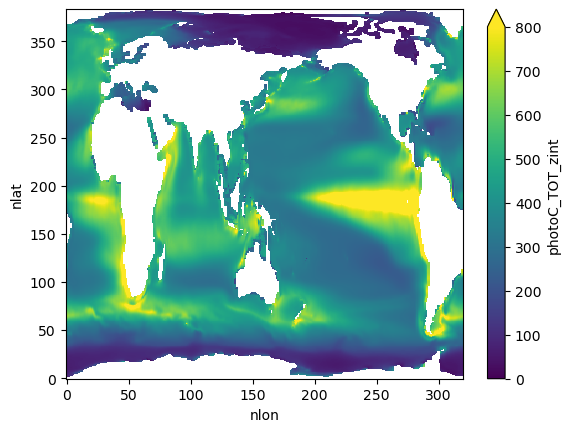

In [47]:
NPP_cesm_mean.plot(vmin=0,vmax=800)

In [48]:
ds_grid = pop_tools.get_grid('POP_gx1v7') #.isel(nlon=slice(500,1100),nlat=slice(1600,2000))
lons_pop=ds_grid.TLONG
lats_pop=ds_grid.TLAT
area_pop=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons_pop)

In [49]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [50]:
ts_box1_cesm = xr.Dataset()
mask = ones.where(lats_pop<box1_latmax).where(lats_pop>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
masked_var = NPP_ann_cesm.where(mask==1)
masked_area = area_pop.where(mask==1)
ts_box1_cesm['NPP']  = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

In [51]:
ts_box2_cesm = xr.Dataset()
mask = ones.where(lats_pop<box2_latmax).where(lats_pop>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
masked_var = NPP_ann_cesm.where(mask==1)
masked_area = area_pop.where(mask==1)
ts_box2_cesm['NPP']  = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

In [52]:
ts_box3_cesm = xr.Dataset()
mask = ones.where(lats_pop<box3_latmax).where(lats_pop>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
masked_var = NPP_ann_cesm.where(mask==1)
masked_area = area_pop.where(mask==1)
ts_box3_cesm['NPP']  = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

### Plot some timeseries

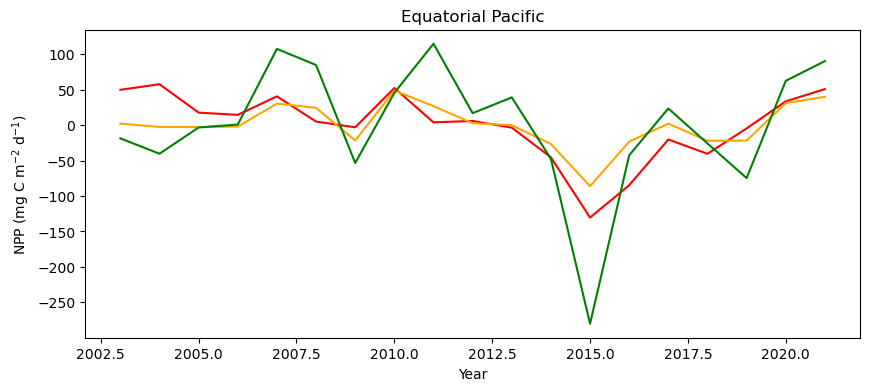

In [53]:
fig, ax1 = plt.subplots(figsize=(10,4))
plt.title('Equatorial Pacific')

ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
ax1.plot(np.arange(2003,2022,1), ts_box1_c['npp']-ts_box1_c['npp'].mean(dim='time'), color='red')
ax1.plot(np.arange(2003,2022,1), ts_box1_v['npp']-ts_box1_v['npp'].mean(dim='time'), color='orange')
ax1.plot(np.arange(2003,2022,1), ts_box1_cesm['NPP'] - ts_box1_cesm['NPP'].mean(dim='time'), color='green')
#ax1.tick_params(axis='y', labelcolor=color)

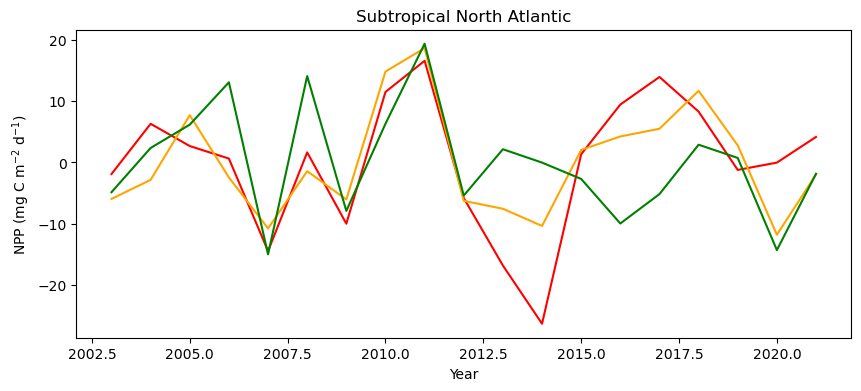

In [54]:
fig, ax1 = plt.subplots(figsize=(10,4))
plt.title('Subtropical North Atlantic')

ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)') #, color=color)
ax1.plot(np.arange(2003,2022,1), ts_box2_c['npp']-ts_box2_c['npp'].mean(dim='time'), color='red')
ax1.plot(np.arange(2003,2022,1), ts_box2_v['npp']-ts_box2_v['npp'].mean(dim='time'), color='orange')
ax1.plot(np.arange(2003,2022,1), ts_box2_cesm['NPP'] - ts_box2_cesm['NPP'].mean(dim='time'), color='green')

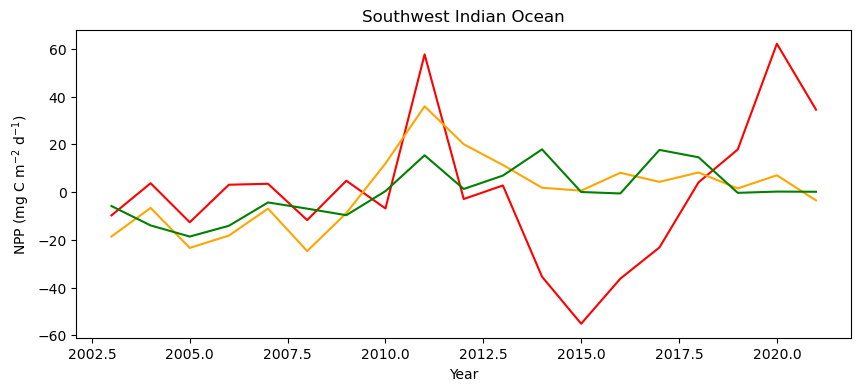

In [55]:
fig, ax1 = plt.subplots(figsize=(10,4))
plt.title('Southwest Indian Ocean')

ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)') #, color=color)
ax1.plot(np.arange(2003,2022,1), ts_box3_c['npp']-ts_box3_c['npp'].mean(dim='time'), color='red')
ax1.plot(np.arange(2003,2022,1), ts_box3_v['npp']-ts_box3_v['npp'].mean(dim='time'), color='orange')
ax1.plot(np.arange(2003,2022,1), ts_box3_cesm['NPP'] - ts_box3_cesm['NPP'].mean(dim='time'), color='green')

In [56]:
import cmocean

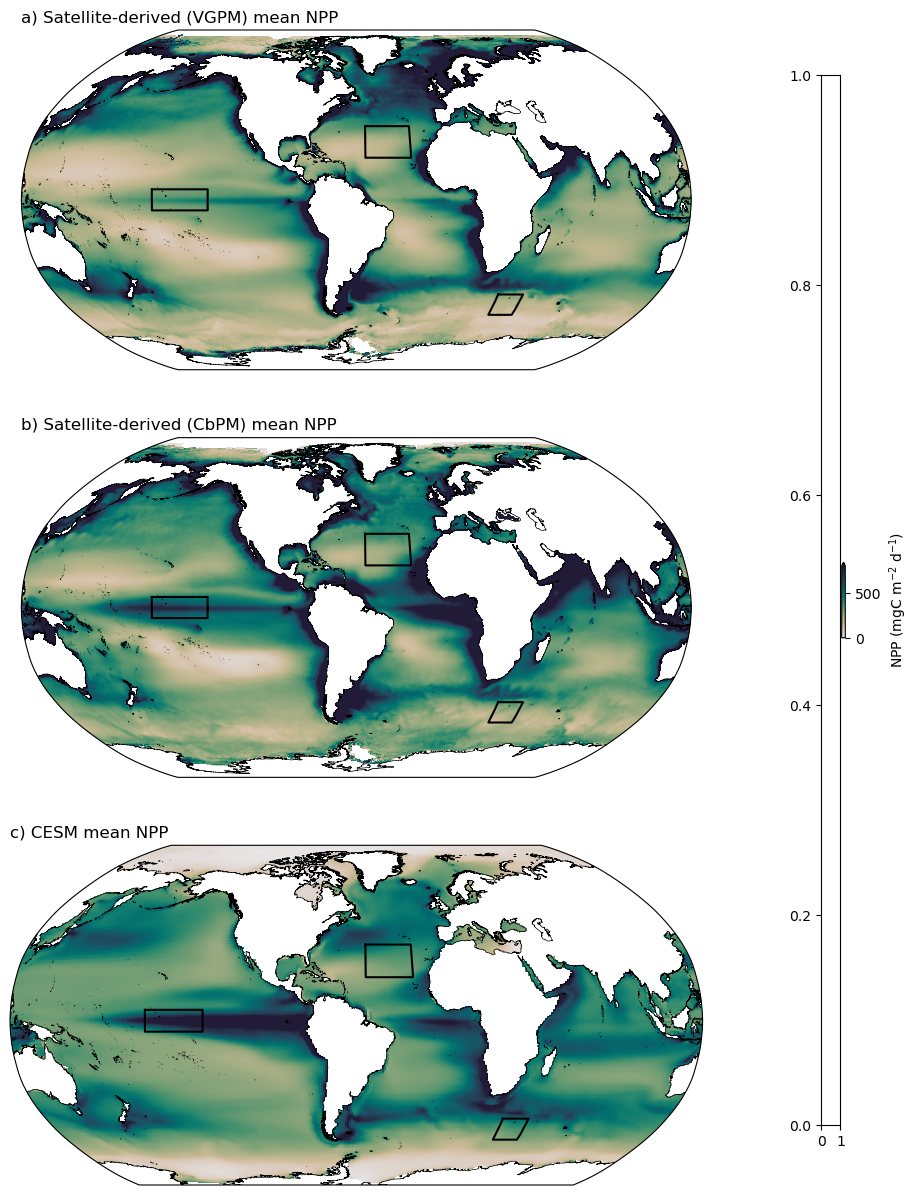

In [57]:
fig = plt.figure(figsize=(12,15))


#----------
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Satellite-derived (VGPM) mean NPP', loc='left')

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat, 
                 ds_vgpm_mean.NPP,
                 vmin=0, vmax=800, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

############################
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) Satellite-derived (CbPM) mean NPP', loc='left')

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat, 
                 ds_cbpm_mean.npp,
                 vmin=0, vmax=800, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

############################
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) CESM mean NPP', loc='left')

ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons_pop, lats_pop, NPP_cesm_mean)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=800, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

############
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, ax=cbar_ax,extend='max',label='NPP (mgC m$^{-2}$ d$^{-1}$)')

In [58]:
def make_line(ts1,ts2):
    ### create model line
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts1,ts2)
    val_min = np.int(np.floor(ts1.min().values))
    val_max = np.int(np.ceil(ts1.max().values))
    i=0
    model_yvar = np.empty([val_max-val_min+1])
    for val in np.arange(val_min,val_max+1,1):
        model_yvar[i] = slope * val + intercept
        i = i + 1
    return(val_min,val_max,model_yvar,slope,intercept,r_value,p_value)

In [59]:
import matplotlib.gridspec as gridspec

In [60]:
import matplotlib.colors as colors

#### Make a figure with some timeseries

In [61]:
box1_mean_c = ts_box1_c['npp'].mean(dim='time')
box1_mean_v = ts_box1_v['npp'].mean(dim='time')
box1_mean_cesm = ts_box1_cesm.NPP.mean(dim='time')

box2_mean_c = ts_box2_c['npp'].mean(dim='time')
box2_mean_v = ts_box2_v['npp'].mean(dim='time')
box2_mean_cesm = ts_box2_cesm.NPP.mean(dim='time')

box3_mean_c = ts_box3_c['npp'].mean(dim='time')
box3_mean_v = ts_box3_v['npp'].mean(dim='time')
box3_mean_cesm = ts_box3_cesm.NPP.mean(dim='time')

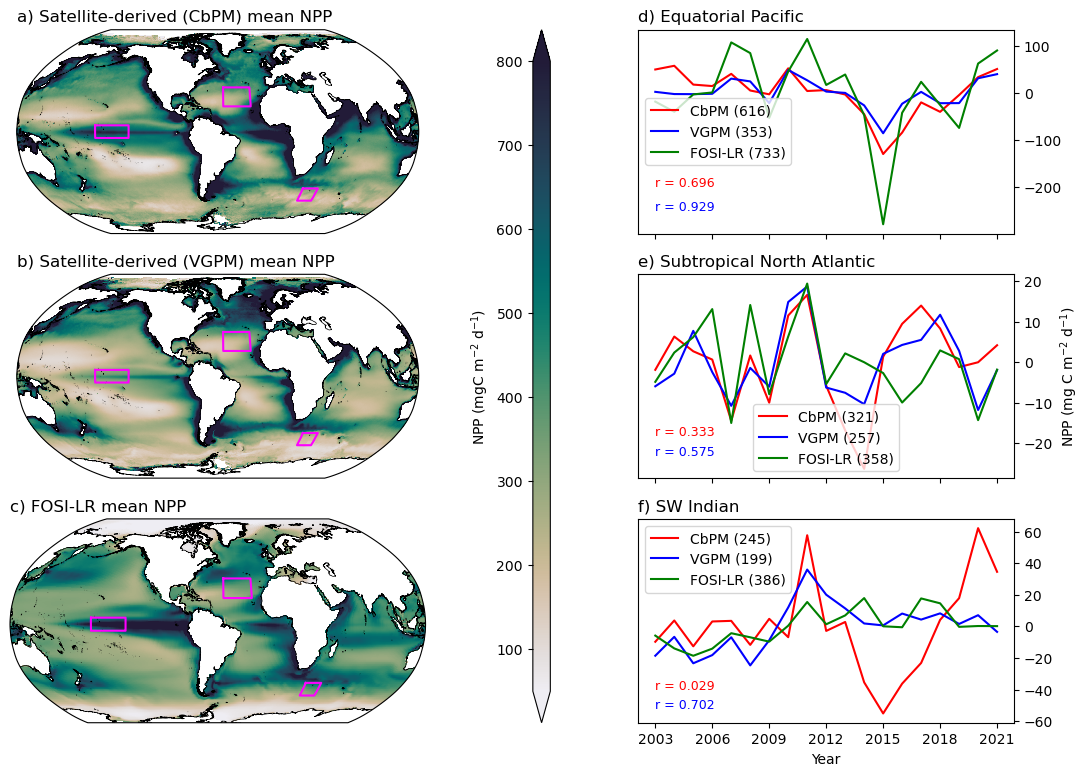

In [62]:
fig = plt.figure(figsize=(14,9))

gs = gridspec.GridSpec(nrows=3, ncols=7, width_ratios=(1, 1, 1, 0.1, 0.2, 1,1), height_ratios=(1,1,1))

prj = ccrs.Robinson(central_longitude=305.0)

box_color='magenta'

ax_npp_v = plt.subplot(gs[1,0:3], projection=prj)
ax_npp_c = plt.subplot(gs[0,0:3], projection=prj)
ax_npp_cesm = plt.subplot(gs[2,0:3], projection=prj)

cb_ax = plt.subplot(gs[0:3, 3])
sc1 = plt.subplot(gs[0, 5:7])
sc2 = plt.subplot(gs[1, 5:7])
sc3 = plt.subplot(gs[2, 5:7])

### NPP from satellite

#ax_npp_v.set_extent([-180, 180, -80, 80], ccrs.PlateCarree())
ax_npp_v.set_title('b) Satellite-derived (VGPM) mean NPP', loc='left')
ax_npp_v.coastlines('10m',linewidth=0.5)
pc1 = ax_npp_v.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat, 
                 ds_vgpm_mean.NPP,
                 #norm=colors.LogNorm(vmin=50, vmax=800),
                 vmin=50, vmax=800,
                 cmap=cmocean.cm.rain, #'jet',
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_npp_v.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_npp_v.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_npp_v.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())
   
#######################################

#ax_npp_c.set_extent([-180, 180, -80, 80], ccrs.PlateCarree())
ax_npp_c.set_title('a) Satellite-derived (CbPM) mean NPP', loc='left')
ax_npp_c.coastlines('10m',linewidth=0.5)
pc1 = ax_npp_c.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat, 
                 ds_cbpm_mean.npp,
                 #norm=colors.LogNorm(vmin=50, vmax=800),
                 vmin=50, vmax=800,
                 cmap=cmocean.cm.rain, #'jet',
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_npp_c.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_npp_c.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_npp_c.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())
    
    
    
#######################################

#ax_npp_cesm.set_extent([-180, 180, -80, 80], ccrs.PlateCarree())
ax_npp_cesm.set_title('c) FOSI-LR mean NPP', loc='left')
ax_npp_cesm.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons_pop, lats_pop, NPP_cesm_mean)
pc2 = ax_npp_cesm.pcolormesh(lon, lat, 
                 field,
                 #norm=colors.LogNorm(vmin=50, vmax=800),
                 vmin=50, vmax=800,
                 cmap=cmocean.cm.rain, #'jet',
                 transform=ccrs.PlateCarree())

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_npp_cesm.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_npp_cesm.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_npp_cesm.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())  
    
    
###########################



cb_chl = plt.colorbar(pc2, cax=cb_ax,extend='both', label='NPP (mgC m$^{-2}$ d$^{-1}$)')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')
###########################

#sc1.set_xlabel('VGPM NPP (mg C m$^{-2}$ d$^{-1}$)')
#sc1.set_ylabel('CESM NPP (mg C m$^{-2}$ d$^{-1}$)')
sc1.set_title('d) Equatorial Pacific',loc='left') #,x=0.33,y=0.85)
#sc1.set_xlabel('Year')
#sc1.set_ylabel('VGPM NPP (mg C m$^{-2}$ d$^{-1}$)', color=color)
sc1.plot(np.arange(2003,2022,1), ts_box1_c['npp']-ts_box1_c['npp'].mean(dim='time'), color='red', label='CbPM ('+str(np.int(box1_mean_c.values))+')')
sc1.plot(np.arange(2003,2022,1), ts_box1_v['npp']-ts_box1_v['npp'].mean(dim='time'), color='blue', label='VGPM ('+str(np.int(box1_mean_v.values))+')')
sc1.plot(np.arange(2003,2022,1), ts_box1_cesm['NPP']-ts_box1_cesm['NPP'].mean(dim='time'), color='green', label='FOSI-LR ('+str(np.int(box1_mean_cesm.values))+')')
sc1.set_xticks([2003, 2006, 2009, 2012, 2015, 2018, 2021])
sc1.axes.xaxis.set_ticklabels([])
sc1.yaxis.set_label_position("right")
sc1.yaxis.tick_right()

#### add r and p values
val_min,val_max,model_npp,slope,b,r,p = make_line(ts_box1_v['npp']-ts_box1_v['npp'].mean(dim='time'),ts_box1_cesm['NPP']-ts_box1_cesm['NPP'].mean(dim='time'))
sc1.text(2003,-250,'r = ' + str(np.round(r,3)),fontsize=9, color='blue')

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_box1_c['npp']-ts_box1_c['npp'].mean(dim='time'),ts_box1_cesm['NPP']-ts_box1_cesm['NPP'].mean(dim='time'))
sc1.text(2003,-200,'r = ' + str(np.round(r,3)),fontsize=9, color='red')

sc1.legend(loc='center left')
#sc1.text(2003,530,'p = ' + str(np.format_float_scientific(p, precision=3)),fontsize=7)


#######################################
#sc2.set_xlabel('VGPM NPP (mg C m$^{-2}$ d$^{-1}$)')

sc2.set_title('e) Subtropical North Atlantic', loc='left') #,x=0.475,y=0.85)

#sc2.set_xlabel('Year')
sc2.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
sc2.plot(np.arange(2003,2022,1), ts_box2_c['npp']-ts_box2_c['npp'].mean(dim='time'), color='red', label='CbPM ('+str(np.int(box2_mean_c.values))+')')
sc2.plot(np.arange(2003,2022,1), ts_box2_v['npp']-ts_box2_v['npp'].mean(dim='time'), color='blue', label='VGPM ('+str(np.int(box2_mean_v.values))+')')
sc2.plot(np.arange(2003,2022,1), ts_box2_cesm['NPP']-ts_box2_cesm['NPP'].mean(dim='time'), color='green', label='FOSI-LR ('+str(np.int(box2_mean_cesm.values))+')')
sc2.set_xticks([2003, 2006, 2009, 2012, 2015, 2018, 2021])
sc2.axes.xaxis.set_ticklabels([])
sc2.yaxis.set_label_position("right")
sc2.yaxis.tick_right()

#### add r and p values
val_min,val_max,model_npp,slope,b,r,p = make_line(ts_box2_v['npp']-ts_box2_v['npp'].mean(dim='time'),ts_box2_cesm['NPP']-ts_box2_cesm['NPP'].mean(dim='time'))
sc2.text(2003,-23,'r = ' + str(np.round(r,3)),fontsize=9, color='blue')

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_box2_c['npp']-ts_box2_c['npp'].mean(dim='time'),ts_box2_cesm['NPP']-ts_box2_cesm['NPP'].mean(dim='time'))
sc2.text(2003,-18,'r = ' + str(np.round(r,3)),fontsize=9, color='red')
sc2.legend()



##############################################
sc3.set_title('f) SW Indian', loc='left') #x=0.22,y=0.85)

sc3.set_xlabel('Year')
#sc3.set_ylabel('VGPM NPP (mg C m$^{-2}$ d$^{-1}$)', color=color)
#sc3.set_ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
sc3.plot(np.arange(2003,2022,1), ts_box3_c['npp']-ts_box3_c['npp'].mean(dim='time'), color='red', label='CbPM ('+str(np.int(box3_mean_c.values))+')')
sc3.plot(np.arange(2003,2022,1), ts_box3_v['npp']-ts_box3_v['npp'].mean(dim='time'), color='blue', label='VGPM ('+str(np.int(box3_mean_v.values))+')')
sc3.plot(np.arange(2003,2022,1), ts_box3_cesm['NPP']-ts_box3_cesm['NPP'].mean(dim='time'), color='green', label='FOSI-LR ('+str(np.int(box3_mean_cesm.values))+')')
#sc3.axes.xaxis.set_ticklabels([]) 
sc3.yaxis.set_label_position("right")
sc3.yaxis.tick_right()
sc3.legend(loc='upper left')
plt.xticks([2003, 2006, 2009, 2012, 2015, 2018, 2021])
#### add r and p values
val_min,val_max,model_npp,slope,b,r,p = make_line(ts_box3_v['npp']-ts_box3_v['npp'].mean(dim='time'),ts_box3_cesm['NPP']-ts_box3_cesm['NPP'].mean(dim='time'))
sc3.text(2003,-52,'r = ' + str(np.round(r,3)),fontsize=9, color='blue')

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_box3_c['npp']-ts_box3_c['npp'].mean(dim='time'),ts_box3_cesm['NPP']-ts_box3_cesm['NPP'].mean(dim='time'))
sc3.text(2003,-40,'r = ' + str(np.round(r,3)),fontsize=9, color='red')

#fig.subplots_adjust(hspace=0.4,wspace=0.25);

fig.savefig('/glade/work/kristenk/figs/NPP_sat_cesm_x1.png', bbox_inches='tight', dpi=300, format='png');